<a href="https://colab.research.google.com/github/amien1410/colab-notebooks/blob/main/Colab_Pyspark_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Install Kaggle modules and download the dataset

from google.colab import drive
drive.mount('/content/drive')

!pip install kaggle
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'
!kaggle datasets download -d dansbecker/melbourne-housing-snapshot
!unzip -q "/content/melbourne-housing-snapshot.zip"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset URL: https://www.kaggle.com/datasets/dansbecker/melbourne-housing-snapshot
License(s): CC-BY-NC-SA-4.0
  0% 0.00/451k [00:00<?, ?B/s]
100% 451k/451k [00:00<00:00, 399MB/s]


In [1]:
# Download dataset
!wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
!unzip -q "/content/bank+marketing.zip"
!unzip -q "/content/bank.zip"

--2025-06-18 14:36:45--  https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank+marketing.zip’

bank+marketing.zip      [    <=>             ] 999.85K  1.06MB/s    in 0.9s    

2025-06-18 14:36:46 (1.06 MB/s) - ‘bank+marketing.zip’ saved [1023843]



In [2]:
# load the dataset and perform EDA-based variable selections.
filename = "bank-full.csv"
target_variable_name = "y" #This variable can be set later too

# Load the data using the following code:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
df = spark.read.csv(filename, header=True, inferSchema=True, sep=';')
df.show()

+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|age|         job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
| 58|  management| married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|     261|       1|   -1|       0| unknown| no|
| 44|  technician|  single|secondary|     no|     29|    yes|  no|unknown|  5|  may|     151|       1|   -1|       0| unknown| no|
| 33|entrepreneur| married|secondary|     no|      2|    yes| yes|unknown|  5|  may|      76|       1|   -1|       0| unknown| no|
| 47| blue-collar| married|  unknown|     no|   1506|    yes|  no|unknown|  5|  may|      92|       1|   -1|       0| unknown| no|
| 33|     unknown|  single|  unknown|     no|      1|     no|  no|unknown|  5|  may

In [ ]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



In [ ]:
# Length of the data
df.count()

45211

In [ ]:
#describes data
df.describe().toPandas()

,summary,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,count,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211
1,mean,40.93621021432837,None,None,None,None,1362.2720576850766,None,None,None,15.80641879188693,None,258.1630797814691,2.763840658246887,40.19782796222158,0.5803233726305546,None,None
2,stddev,10.618762040975408,None,None,None,None,3044.7658291685243,None,None,None,8.322476153044596,None,257.52781226517095,3.098020883279184,100.12874599059813,2.3034410449312204,None,None
3,min,18,admin.,divorced,primary,no,-8019,no,no,cellular,1,apr,0,1,-1,0,failure,no
4,max,95,unknown,single,unknown,yes,102127,yes,yes,unknown,31,sep,4918,63,871,275,unknown,yes


In [ ]:
#type of each variable
df.dtypes
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



In [ ]:
#single variable count by group
df.groupBy('education').count().show()

+---------+-----+
|education|count|
+---------+-----+
|  unknown| 1857|
| tertiary|13301|
|secondary|23202|
|  primary| 6851|
+---------+-----+



In [ ]:
#multiple column group by
df.groupBy(['education',target_variable_name]).count().show()

+---------+---+-----+
|education|  y|count|
+---------+---+-----+
|  unknown| no| 1605|
| tertiary| no|11305|
|secondary| no|20752|
|  unknown|yes|  252|
|  primary| no| 6260|
|  primary|yes|  591|
|secondary|yes| 2450|
| tertiary|yes| 1996|
+---------+---+-----+



In [ ]:
#column aggregations
from pyspark.sql.functions import *
df.groupBy(target_variable_name).agg({'balance':'avg', 'age':'avg'}).show()

+---+------------------+------------------+
|  y|      avg(balance)|          avg(age)|
+---+------------------+------------------+
| no|1303.7149691899203| 40.83898602274435|
|yes|1804.2679145396105|41.670069956513515|
+---+------------------+------------------+



# Analyzing Cardinality in Spark DataFrame

This section aims to analyze the cardinality (number of unique values) of each column in a Spark DataFrame. The goal is to identify any columns with low cardinality based on a specified threshold (`cut_off`). The results will be retrieved in a structured format using pandas for easier manipulation and interpretation.

In [3]:
# Cardinality Check
from pyspark.sql.functions import approxCountDistinct, countDistinct

"""
Note: approxCountDistinct and countDistinct can be used interchangeably.
Only difference is the computation time.
"approxCountDistinct" is useful for large datasets
"countDistinct" for small and medium datasets.
"""
def cardinality_calculation(df, cut_off=1):
    cardinality = df.select(*[approxCountDistinct(c).alias(c) for c in
    df.columns])
    ## convert to pandas for efficient calculations
    final_cardinality_df = cardinality.toPandas().transpose()
    final_cardinality_df.reset_index(inplace=True)
    final_cardinality_df.rename(columns={0:'Cardinality'}, inplace=True)
    #select variables with cardinality of 1
    vars_selected = final_cardinality_df['index'][final_cardinality_df['Cardinality'] <= cut_off]
    return final_cardinality_df, vars_selected

cardinality_df, cardinality_vars_selected = cardinality_calculation(df)

/usr/local/lib/python3.11/dist-packages/pyspark/sql/functions.py:3796: FutureWarning: Deprecated in 2.1, use approx_count_distinct instead.
  warnings.warn("Deprecated in 2.1, use approx_count_distinct instead.", FutureWarning)


In [ ]:
cardinality_df

,index,Cardinality
0,age,76
1,job,11
2,marital,3
3,education,4
4,default,2
5,balance,7375
6,housing,2
7,loan,2
8,contact,3
9,day,32


In [ ]:
cardinality_vars_selected

,index


In [4]:
# Missing values check
from pyspark.sql.functions import count, when, isnan, col

# miss_percentage is set to 80% as discussed in the book
def missing_calculation(df, miss_percentage=0.80):
    # checks for both NaN and null values
    missing = df.select(*[count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])

    # Calculate total length of the DataFrame
    length_df = df.count()

    ## convert to pandas for efficient calculations
    final_missing_df = missing.toPandas().transpose()
    final_missing_df.reset_index(inplace=True)
    final_missing_df.rename(columns={0:'missing_count'}, inplace=True)
    final_missing_df['missing_percentage'] = final_missing_df['missing_count']/length_df

    #select variables with missing percentage greater than or equal to the threshold
    vars_selected = final_missing_df['index'][final_missing_df['missing_percentage'] >= miss_percentage]
    return final_missing_df, vars_selected

missing_df, missing_vars_selected = missing_calculation(df)

In [5]:
# Identify variable types
def variable_type(df):
    # use the dtypes to separate character and numeric variables
    vars_list = df.dtypes
    char_vars = []  # character variables list
    num_vars = []  # numeric variable list
    for i in vars_list:
        if i[1] in ('string'):
            char_vars.append(i[0])
        else:
            num_vars.append(i[0])
    return char_vars, num_vars

# apply variable_type function on our DataFrame
char_vars, num_vars = variable_type(df)

In [6]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

#converts each category column to index
def category_to_index(df, char_vars):
    char_df = df.select(char_vars)
    indexers = [StringIndexer(inputCol=c, outputCol=c+"_index", handleInvalid="keep") for c in char_df.columns]
    pipeline = Pipeline(stages=indexers)
    char_labels = pipeline.fit(char_df)
    df = char_labels.transform(df)
    return df, char_labels

#apply category_to_index function on our DataFrame
df, char_labels = category_to_index(df, char_vars)

In [7]:
df.show(10)

+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+--------------+-------+
|age|         job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|job_index|marital_index|education_index|default_index|housing_index|loan_index|contact_index|month_index|poutcome_index|y_index|
+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+--------------+-------+
| 58|  management| married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|     261|       1|   -1|       0| unknown| no|      1.0|          0.0|            1.0|          0.0|          0.0|       0.0|          1.0|

In [8]:
df = df.select([c for c in df.columns if c not in char_vars])

In [9]:
#rename _index columns to original variable name
def rename_columns(df, char_vars):
    mapping = dict(zip([i + '_index' for i in char_vars], char_vars))
    df = df.select([col(c).alias(mapping.get(c, c)) for c in df.columns])
    return df

# apply rename_columns to our DataFrame
df = rename_columns(df, char_vars)

In [10]:
# Apply StringIndexer to the target variable 'y'
# StringIndexer maps a string column to an index column.
# handleInvalid="skip" will skip rows with invalid data.
indexer = StringIndexer(inputCol='y', outputCol='y_index', handleInvalid='skip')
indexerModel = indexer.fit(df)

# Transform the DataFrame using the fitted StringIndexer model
df = indexerModel.transform(df)

# Drop the original "y" column as it is now redundant
df = df.drop(df.y)

# Rename the new "y_index" column back to "y" for consistency
df = df.withColumnRenamed('y_index', 'y')

# Display the updated DataFrame schema to see the change
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- balance: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- job: double (nullable = false)
 |-- marital: double (nullable = false)
 |-- education: double (nullable = false)
 |-- default: double (nullable = false)
 |-- housing: double (nullable = false)
 |-- loan: double (nullable = false)
 |-- contact: double (nullable = false)
 |-- month: double (nullable = false)
 |-- poutcome: double (nullable = false)
 |-- y: double (nullable = false)



## Assembling Features

To prepare the data for machine learning models, we need to combine all the input features into a single vector. This is like gathering all the ingredients for a recipe into one bowl before mixing. PySpark's `VectorAssembler` helps us do this.

After creating this feature vector, you might also want to scale your data. Scaling helps ensure that no single feature has too much influence on the model just because it has larger values. We can use `StandardScaler` or `MinMaxScaler` for this.

In [11]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

# Define a function to assemble feature columns into a single vector column
def assemble_vectors(df, features_list, target_variable_name):
    """
    Assembles multiple feature columns into a single vector column named 'features'.

    Args:
        df: The input Spark DataFrame.
        features_list: A list of column names to be assembled into the feature vector.
        target_variable_name: The name of the target variable column.

    Returns:
        A Spark DataFrame with the original target variable and the new 'features' vector column.
    """
    # Create a VectorAssembler instance
    # inputCols: list of columns to be assembled
    # outputCol: name of the new vector column
    assembler = VectorAssembler(inputCols=features_list, outputCol='features')

    # Create a pipeline with the VectorAssembler stage
    # Pipelines help organize and run multiple data processing steps sequentially
    pipeline = Pipeline(stages=[assembler])

    # Fit the pipeline to the DataFrame to create the assembler model
    assembleModel = pipeline.fit(df)

    # Transform the DataFrame using the fitted assembler model
    # This adds the new 'features' vector column to the DataFrame
    df = assembleModel.transform(df)

    # Select only the target variable column and the new 'features' column
    # This keeps the DataFrame focused on the input for the model and the output
    selectedCols = [target_variable_name, 'features']
    df = df.select(selectedCols)

    return df

# Identify the feature columns by excluding the target variable
features_list = [col for col in df.columns if col != target_variable_name]

# Apply the assemble_vectors function to the DataFrame
df = assemble_vectors(df, features_list, target_variable_name)

# Display the schema of the updated DataFrame to see the new 'features' column
df.printSchema()

# Show the first few rows of the updated DataFrame
df.show(5)

root
 |-- y: double (nullable = false)
 |-- features: vector (nullable = true)

+---+--------------------+
|  y|            features|
+---+--------------------+
|0.0|(16,[0,1,2,3,4,5,...|
|0.0|(16,[0,1,2,3,4,5,...|
|0.0|(16,[0,1,2,3,4,5,...|
|0.0|(16,[0,1,2,3,4,5,...|
|0.0|[33.0,1.0,5.0,198...|
+---+--------------------+
only showing top 5 rows



In [12]:
df.schema["features"].metadata["ml_attr"]["attrs"]

{'numeric': [{'idx': 0, 'name': 'age'},
  {'idx': 1, 'name': 'balance'},
  {'idx': 2, 'name': 'day'},
  {'idx': 3, 'name': 'duration'},
  {'idx': 4, 'name': 'campaign'},
  {'idx': 5, 'name': 'pdays'},
  {'idx': 6, 'name': 'previous'}],
 'nominal': [{'vals': ['blue-collar',
    'management',
    'technician',
    'admin.',
    'services',
    'retired',
    'self-employed',
    'entrepreneur',
    'unemployed',
    'housemaid',
    'student',
    'unknown',
    '__unknown'],
   'idx': 7,
   'name': 'job'},
  {'vals': ['married', 'single', 'divorced', '__unknown'],
   'idx': 8,
   'name': 'marital'},
  {'vals': ['secondary', 'tertiary', 'primary', 'unknown', '__unknown'],
   'idx': 9,
   'name': 'education'},
  {'vals': ['no', 'yes', '__unknown'], 'idx': 10, 'name': 'default'},
  {'vals': ['yes', 'no', '__unknown'], 'idx': 11, 'name': 'housing'},
  {'vals': ['no', 'yes', '__unknown'], 'idx': 12, 'name': 'loan'},
  {'vals': ['cellular', 'unknown', 'telephone', '__unknown'],
   'idx': 13,


In [13]:
import pandas as pd

# Initialize an empty list to store the attribute information
feature_attributes_list = []

# Iterate over metadata attributes in the 'features' column
# The structure is typically {'numeric': [...], 'nominal': [...]}
for k, v in df.schema["features"].metadata["ml_attr"]["attrs"].items():
    # 'v' is a list of dictionaries, each representing an attribute
    for attribute_dict in v:
        # Append each attribute dictionary to the list
        feature_attributes_list.append(attribute_dict)

# Convert the list of dictionaries into a pandas DataFrame
features_df = pd.DataFrame(feature_attributes_list)

# Display the resulting pandas DataFrame
display(features_df)

,idx,name,vals
0,0,age,NaN
1,1,balance,NaN
2,2,day,NaN
3,3,duration,NaN
4,4,campaign,NaN
5,5,pdays,NaN
6,6,previous,NaN
7,7,job,"[blue-collar, management, technician, admin., ..."
8,8,marital,"[married, single, divorced, __unknown]"
9,9,education,"[secondary, tertiary, primary, unknown, __unkn..."


In [ ]:
df.groupBy('y').count().show()

+---+-----+
|  y|count|
+---+-----+
|0.0|39922|
|1.0| 5289|
+---+-----+



In [14]:
from pyspark.ml.feature import PCA
# Importing Vectors is not necessary for PCA transformation itself, but it's good practice
# if you were to manually create vectors.
# from pyspark.ml.linalg import Vectors


# Define the number of principal components to keep
no_of_components = 3

# Initialize PCA with the desired number of components and specify input/output columns
# inputCol="features" indicates that PCA will be applied to the 'features' vector column
# outputCol="pcaFeatures" is the name of the new column that will store the PCA-transformed features
pca = PCA(k=no_of_components, inputCol="features", outputCol="pcaFeatures")

# Fit the PCA model to the DataFrame
# This step calculates the principal components based on the data in the 'features' column
model = pca.fit(df)

# Transform the DataFrame using the fitted PCA model
# This applies the PCA transformation and adds the 'pcaFeatures' column to the DataFrame
result = model.transform(df)

# Select only the 'pcaFeatures' column to display the results of the transformation
result.select("pcaFeatures").show(truncate=False)

# You can also display the explained variance ratio for each component
print("Explained Variance Ratio:")
print(model.explainedVariance)

+------------------------------------------------------------+
|pcaFeatures                                                 |
+------------------------------------------------------------+
|[-2143.4953647735815,-257.0420740676505,1.244971275304795]  |
|[-29.2922617516463,-150.92888640669167,1.0493026899279936]  |
|[-2.150889773941893,-75.98191250436612,1.0760651955381264]  |
|[-1506.182330590812,-89.215471546727,1.2683999536976094]    |
|[-1.375090834944834,-197.98356175494823,0.9892427009816441] |
|[-231.26679712386624,-138.56034919503713,1.057696089139628] |
|[-447.4072782675641,-216.16541383839746,1.0066666548031191] |
|[-2.7123264447442366,-379.9785828164355,0.8751504698368221] |
|[-121.11144848214052,-49.75636025970779,1.1725853591924071] |
|[-593.1146061641075,-53.893642618320335,1.181702273226208]  |
|[-270.4212341323417,-221.48699661827916,1.017082407320575]  |
|[-390.2608167665409,-136.27016909339133,1.0625336862699812] |
|[-6.967616100129205,-516.9674558248697,0.8003545768071

In [15]:
model.pc.toArray()

array([[-3.41021399e-04,  2.79524640e-04,  2.58353293e-03],
       [-9.99998245e-01,  1.83654726e-03,  1.13892524e-04],
       [-1.22934480e-05,  9.79995613e-04,  7.79347982e-03],
       [-1.83671689e-03, -9.99996986e-01, -7.36955549e-04],
       [ 1.48468991e-05,  1.01391994e-03,  2.75121381e-03],
       [-1.13085547e-04,  7.49207153e-04, -9.99889046e-01],
       [-1.26153895e-05, -6.36100089e-06, -1.04654388e-02],
       [-1.78789640e-05, -4.11817349e-05,  5.51411389e-04],
       [ 6.41085932e-06, -5.23364803e-05, -1.45349520e-04],
       [-1.11185424e-05,  1.30366514e-05,  2.01500982e-04],
       [ 2.91665702e-06,  4.42643869e-06,  3.95562163e-05],
       [-1.12221341e-05,  1.26153926e-05,  6.17569266e-04],
       [ 1.01623400e-05,  1.50687571e-05,  8.23933054e-05],
       [-5.68377754e-07,  6.95393403e-05,  1.03951369e-03],
       [-7.60886236e-05, -1.16754927e-04, -3.24662847e-03],
       [-8.55162111e-06, -6.01853226e-05, -4.94522998e-03]])

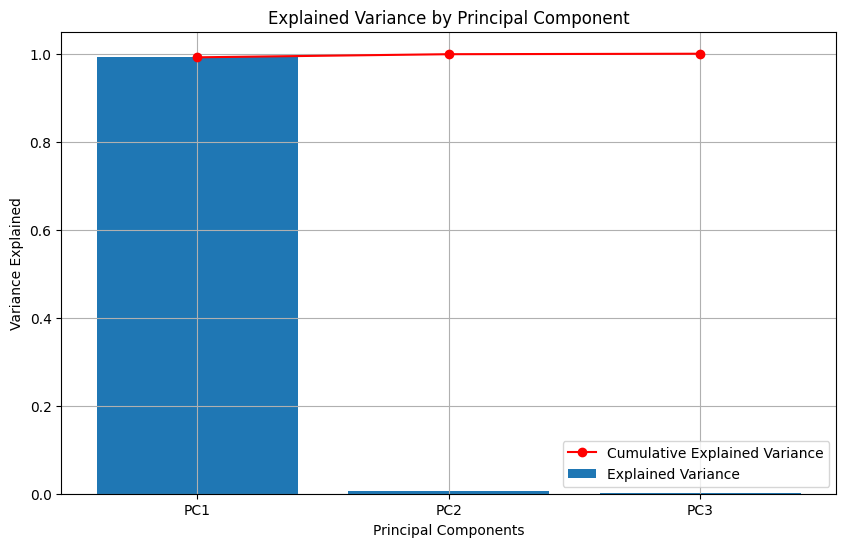

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Create labels for the principal components (e.g., PC1, PC2, PC3)
x = []
for i in range(0, len(model.explainedVariance)):
    x.append('PC' + str(i + 1))

# Get the explained variance ratio for each principal component
y = np.array(model.explainedVariance)

# Calculate the cumulative explained variance
z = np.cumsum(model.explainedVariance)

# Create the plot
plt.figure(figsize=(10, 6)) # Set figure size for better readability

# Plot the explained variance for each component as a bar chart
plt.bar(x, y, label='Explained Variance')

# Plot the cumulative explained variance as a line graph
plt.plot(x, z, marker='o', color='red', label='Cumulative Explained Variance')

# Add labels and title
plt.xlabel('Principal Components')
plt.ylabel('Variance Explained')
plt.title('Explained Variance by Principal Component')

# Add a legend to the plot
plt.legend()

# Show the plot
plt.grid(True) # Add a grid for better readability
plt.show()

In [17]:
from pyspark.ml.feature import PCA
# Importing Vectors is not necessary for PCA transformation itself, but it's good practice
# if you were to manually create vectors.
# from pyspark.ml.linalg import Vectors


# Define the number of principal components to keep
no_of_components = 3

# Initialize PCA with the desired number of components and specify input/output columns
# inputCol="features" indicates that PCA will be applied to the 'features' vector column
# outputCol="pcaFeatures" is the name of the new column that will store the PCA-transformed features
pca = PCA(k=no_of_components, inputCol="features", outputCol="pcaFeatures")

# Fit the PCA model to the DataFrame
# This step calculates the principal components based on the data in the 'features' column
model = pca.fit(df)

# Transform the DataFrame using the fitted PCA model
# This applies the PCA transformation and adds the 'pcaFeatures' column to the DataFrame
result = model.transform(df)

# Select only the 'pcaFeatures' column to display the results of the transformation
result.select("pcaFeatures").show(truncate=False)

# You can also display the explained variance ratio for each component
print("Explained Variance Ratio:")
print(model.explainedVariance)

+------------------------------------------------------------+
|pcaFeatures                                                 |
+------------------------------------------------------------+
|[-2143.4953647735815,-257.0420740676505,1.244971275304795]  |
|[-29.2922617516463,-150.92888640669167,1.0493026899279936]  |
|[-2.150889773941893,-75.98191250436612,1.0760651955381264]  |
|[-1506.182330590812,-89.215471546727,1.2683999536976094]    |
|[-1.375090834944834,-197.98356175494823,0.9892427009816441] |
|[-231.26679712386624,-138.56034919503713,1.057696089139628] |
|[-447.4072782675641,-216.16541383839746,1.0066666548031191] |
|[-2.7123264447442366,-379.9785828164355,0.8751504698368221] |
|[-121.11144848214052,-49.75636025970779,1.1725853591924071] |
|[-593.1146061641075,-53.893642618320335,1.181702273226208]  |
|[-270.4212341323417,-221.48699661827916,1.017082407320575]  |
|[-390.2608167665409,-136.27016909339133,1.0625336862699812] |
|[-6.967616100129205,-516.9674558248697,0.8003545768071

In [19]:
model.explainedVariance

DenseVector([0.9918, 0.0071, 0.0011])

In [21]:
from pyspark.ml.feature import StandardScaler, VectorAssembler, TruncatedSVD
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import numpy as np

# Define the target variable name.
target_variable_name = "y"

# Identify the feature columns by excluding the target variable.
features_list = [c for c in df.columns if c != target_variable_name]

# Assemble feature columns into a single vector column.
assembler = VectorAssembler(inputCols=features_list, outputCol='features')

# Scale the feature vector. Scaling is important for SVD/PCA as it is sensitive to the scale of features.
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)

# Define the number of singular values to keep (similar to number of components in PCA).
# We'll use 5 as in the user's original request.
no_of_components = 5

# Initialize TruncatedSVD with the desired number of components.
# inputCol="scaledFeatures" indicates that SVD will be applied to the scaled features.
# outputCol="svdFeatures" is the name of the new column that will store the SVD-transformed features.
svd = TruncatedSVD(k=no_of_components, inputCol="scaledFeatures", outputCol="svdFeatures")

# Create a pipeline to run the steps sequentially: assemble -> scale -> SVD.
pipeline = Pipeline(stages=[assembler, scaler, svd])

# Fit the pipeline to the DataFrame.
# This step performs the assembly, scaling, and SVD calculation.
model = pipeline.fit(df)

# Transform the DataFrame using the fitted pipeline model.
# This applies the transformations and adds the 'svdFeatures' column.
result = model.transform(df)

# Select and show the SVD-transformed features.
print(f"Showing the first 20 rows of the SVD-transformed features ({no_of_components} components):")
result.select("svdFeatures").show(truncate=False)

# Display the explained variance ratio for each component.
# This shows how much variance each singular value explains.
print("\nExplained Variance Ratio:")
print(model.stages[-1].explainedVariance)

# Plot the explained variance and cumulative explained variance.
explained_variance = model.stages[-1].explainedVariance
cumulative_explained_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10, 6))
plt.bar([f'SV{i+1}' for i in range(no_of_components)], explained_variance, label='Explained Variance')
plt.plot([f'SV{i+1}' for i in range(no_of_components)], cumulative_explained_variance, marker='o', color='red', label='Cumulative Explained Variance')

plt.xlabel('Singular Values (Components)')
plt.ylabel('Variance Explained')
plt.title('Explained Variance by Singular Value')
plt.legend()
plt.grid(True)
plt.show()

ImportError: cannot import name 'TruncatedSVD' from 'pyspark.ml.feature' (/usr/local/lib/python3.11/dist-packages/pyspark/ml/feature.py)

Singular Values:
[709656.9402544986,74266.71444460031,22052.822728476745,6458.186158191573,1846.0544468005473]

V Factor (Principal Components):
DenseMatrix([[-5.32045026e-03,  7.17134065e-02, -6.66155882e-02,
               9.24391757e-01,  3.59273745e-01],
             [-9.99410373e-01, -3.41100513e-02,  2.65017997e-03,
              -2.89441790e-03, -6.24622758e-05],
             [-1.95484507e-03,  2.74592236e-02, -2.00435750e-02,
               3.52915009e-01, -9.30413502e-01],
             [-3.34805136e-02,  9.93450259e-01,  8.25928509e-02,
              -7.15063617e-02,  4.44990809e-04],
             [-3.27512126e-04,  4.37805988e-03, -2.67568306e-03,
               6.55601660e-02, -7.11682726e-02],
             [-5.04431069e-03,  7.70165284e-02, -9.94042767e-01,
              -7.57844715e-02, -5.18910230e-03],
             [-8.19443306e-05,  1.06911241e-03, -1.06408893e-02,
               2.24222659e-03,  2.92603705e-03],
             [-3.47212922e-04,  4.76996462e-03, -3.991305

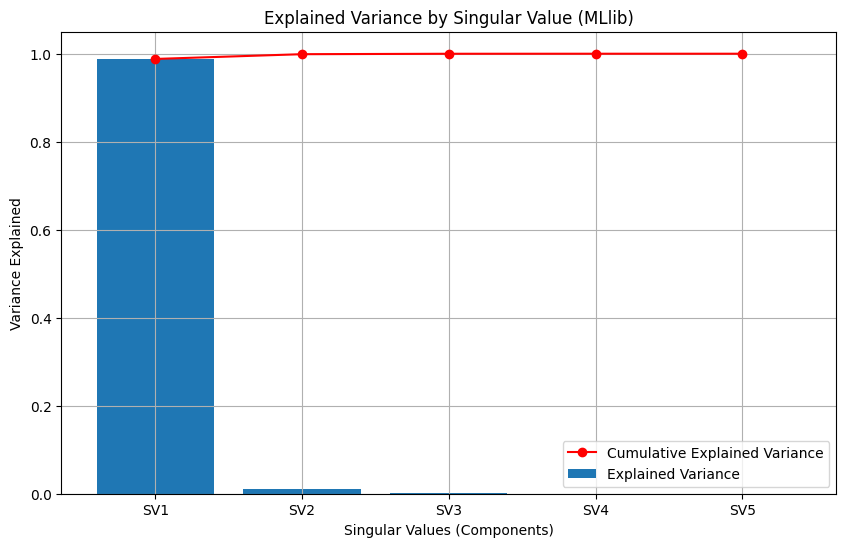

In [22]:
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg.distributed import RowMatrix
import matplotlib.pyplot as plt
import numpy as np

# convert DataFrame to RDD and extract features as array
df_svd_vector = df.rdd.map(lambda x: x['features'].toArray())

#create a Rowmatrix from the RDD of vectors
mat = RowMatrix(df_svd_vector)

# Compute the top 5 singular values and corresponding singular vectors.
# The number of singular values (k) should be less than or equal to the number of features.
no_of_components = 5
svd = mat.computeSVD(no_of_components, computeU=True)

# Extract the results
U = svd.U # The U factor is a RowMatrix.
s = svd.s # The singular values are stored in a local dense vector.
V = svd.V # The V factor is a local dense matrix.

# Display the singular values
print("Singular Values:")
print(s)

# Display the V factor (principal components)
print("\nV Factor (Principal Components):")
print(V)

# Plot the singular values to visualize the explained variance
explained_variance = np.square(s) / np.sum(np.square(s))
cumulative_explained_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10, 6))
plt.bar([f'SV{i+1}' for i in range(no_of_components)], explained_variance, label='Explained Variance')
plt.plot([f'SV{i+1}' for i in range(no_of_components)], cumulative_explained_variance, marker='o', color='red', label='Cumulative Explained Variance')

plt.xlabel('Singular Values (Components)')
plt.ylabel('Variance Explained')
plt.title('Explained Variance by Singular Value (MLlib)')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
# Select only categorical features present in the dataset
# We need to re-run the previous steps to ensure the DataFrame 'df'
# contains the necessary categorical columns as numeric types (after StringIndexing)
# and the 'y' column as a numeric type.

# First, let's get the original DataFrame 'df' before the SVD transformation.
# We need to make sure 'df' contains the StringIndexed categorical variables and the 'y' column.
# Assuming 'df' at this point still contains the dataframe from the previous steps
# with StringIndexed categorical variables and the target variable 'y' as double.

# Identify the categorical feature columns (which are now double after StringIndexing)
# Exclude the target variable 'y'
categorical_features_list = [col for col in df.columns if col in char_vars and col != target_variable_name]

# Re-assemble feature vectors using only the categorical features
assembler_cat = VectorAssembler(inputCols=categorical_features_list, outputCol='features_cat')
df_cat = assembler_cat.transform(df)

# Select only the target variable and the new categorical features vector
df_cat = df_cat.select(target_variable_name, 'features_cat')

# Rename the feature column to "features" to match the ChiSqSelector's expected inputCol
df_cat = df_cat.withColumnRenamed("features_cat", "features")

df_cat.show(5)
df_cat.printSchema()

+---+--------+
|  y|features|
+---+--------+
|0.0|      []|
|0.0|      []|
|0.0|      []|
|0.0|      []|
|0.0|      []|
+---+--------+
only showing top 5 rows

root
 |-- y: double (nullable = false)
 |-- features: vector (nullable = true)



In [ ]:
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.linalg import Vectors

# Define the number of top features to select
num_top_features = 6

# Initialize ChiSqSelector instance
selector = ChiSqSelector(numTopFeatures=num_top_features, featuresCol="features",
                         outputCol="selectedFeatures", labelCol="y")

# Fit on the data containing only categorical features
# Use the df_cat DataFrame created in the previous cell
chi_selector_model = selector.fit(df_cat)

# Transform the DataFrame to get the selected features
result_chi = chi_selector_model.transform(df_cat)

# Get the indices of the selected features
selected_indices = chi_selector_model.selectedFeatures()

# Outputs
print(f"ChiSqSelector output with top {num_top_features} features selected")
print("Selected Indices: ", selected_indices)

# Assuming features_df contains the mapping of original indices to feature names
# Update features_df with chi-square importance (1 if selected, 0 otherwise)
# We need to map the selected indices back to the original feature names.
# First, get the mapping from the assembled categorical features.
feature_attributes_list_cat = []
for k, v in df_cat.schema["features"].metadata["ml_attr"]["attrs"].items():
    for attribute_dict in v:
        feature_attributes_list_cat.append(attribute_dict)
features_df_cat = pd.DataFrame(feature_attributes_list_cat)

# Add a 'chisq_importance' column to features_df_cat
features_df_cat['chisq_importance'] = features_df_cat['idx'].apply(lambda x: 1 if x in selected_indices else 0)

print("\nCategorical Features with Chi-Square Importance:")
display(features_df_cat)